# A software-defined BioMEMS SoC for early breast cancer detection using open-source IP

For a better experience, please open in Colab:

<a target="_blank" href="https://colab.research.google.com/github/luccareinehr/sscs-ose-code-a-chip.github.io/blob/main/ISSCC24/submitted_notebooks/sscs-cancer-biomems/main-notebook.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

```
Submission to IEEE SSCS Open-Source Ecosystem “Code-a-Chip” Travel Grant Awards at ISSCC'24
SPDX-License-Identifier: GPL-3.0-only
```



|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
|Lucca Reinehr Silva (lead) <br /> Email ID: luccareinehr@gmail.com|UFRGS, Brazil <br /> CentraleSupélec, France|Yes|No|
|João Pedro Perin Nunes <br /> Email ID: j.p.perin@gmail.com|UFRJ, Brazil <br /> CentraleSupélec, France|No|No|
|João F. Sulzbach <br /> Email ID: sulzbachjoao@gmail.com|UFRGS, Brazil <br /> CentraleSupélec, France|Yes|No|
|Thales Lobo <br /> Email ID: thalesloboz@gmail.com|Unesp, Brazil <br /> CentraleSupélec, France|No|No|

*The open-source chip design landscape is evergrowing, and existing tools allow for a multitude of systems $-$ although they're mostly focused on digital circuits. Our goal with this project is to show that a complex sensor can also be developed with existing open-source tools and IP designs, for the most part. In this notebook, theoretical BioMEMS sensor for detection of a type of breast cancer is proposed, simulated and its open-source design process is reflected upon.*

## Intro

Cancer is a large group of diseases where cells become disorganised and divide uncontrollably. This, however, does not happen silently. Cell growth on itself and how the body reacts to it create substances called **biomarkers**, which can be measured to detect cancer (in this case). Cancer biomarkers are usually found in body fluids such as blood, urine, or tissue samples, depending on what type of cancer is present [[1]](#ref1-biomarker).

The idea of this project is to leverage a resonating MEMS system to create a cancer biomarker sensor. To be more specific, the biomarker chosen is HER2 (*human epidermal growth factor receptor 2*), a protein that helps control the growth and division of cells. Around 30% of breast cancers have an overexpression of this protein, in which case they are denoted as "HER2-positive" [[2]](#ref2-HER2). This makes the cancer more agressive... but also detectable early by using HER2 as a biomarker.

### The MEMS device

To do that, we'll propose a two-way coupled resonator DETF (*double-ended tuning fork*) system, inspired by an article from Thiruvenkatanathan et al. [[3]](#ref3-coupledDETF). It has a relatively simple geometry, which will help when planning manufacturing (a big challenge in innovative MEMS designs), and is easier to model and couple with another resonator. The two resonators will be electrostatically coupled via a parallel-plate inbetween them. A top-view representation of this mechanical system is shown below.

![](https://raw.githubusercontent.com/luccareinehr/sscs-ose-code-a-chip.github.io/main/ISSCC24/submitted_notebooks/sscs-cancer-biomems/img/coupled-DETF-diagram.png)

*The moving parts of the two resonators are in blue and pink; in normal operation, they vibrate.*

Such a system can detect variations in the structure of each resonator. For instance, if both resonators are identical, they'll have the same resonant frequency (i.e., the frequency of maximum amplitude of oscillation). If there is a slight difference $\Delta M$ in their masses or in their stiffness $\Delta k$, the resonant frequency of both resonators will start to differ. Similarly, in closed-loop excitation with a constant frequency, their oscillation amplitudes will become non-equal.

Thus, by applying an organic coating that captures HER2 proteins in only one of the resonators, its mass will increase according to the number of proteins captured, which creates a difference in resonant frequency (or amplitude) between the resonators that can be measured electrically. For that, the system must be in continuous oscillation, so a closed-loop analog/digital circuitry will also be designed.

We'll envision to create a CMOS/MEMS system with monolithic integration (i.e., the electronic and mechanical parts are in the same silicon die). This way, such a device could not only be used to test patient samples for biomarkers in a lab, but also for in-situ installation of the SoC to detect cancer early in high-risk patients [[4]](#ref4-HER2serum) $-$ in this case, probably combined with an energy harvester for power supply.

## Code-the-chip

### Install dependencies

In [ ]:
# Python packages
!pip install gdsfactory==7.8.17
!pip install sky130==0.9.0
!pip install gdstk==0.9.46
!pip install svgutils==0.3.4

In [ ]:
# Ubuntu packages
!sudo apt-get install ngspice # version: ngspice-36

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ngspice is already the newest version (36+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [ ]:
# Conda packages
import pathlib

!apt install -y time build-essential
!apt install qt5-default qttools5-dev libqt5xmlpatterns5-dev qtmultimedia5-dev libqt5multimediawidgets5 libqt5svg5-dev -y
!apt install ruby ruby-dev libz-dev python3-dev -y
!wget https://www.klayout.org/downloads/Ubuntu-20/klayout_0.28.3-1_amd64.deb
!dpkg -i klayout_0.28.3-1_amd64.deb
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
%env CONDA_PREFIX={CONDA_PREFIX}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        magic \
                        open_pdks.sky130a \
                        openroad \
                        netgen \
                        yosys

Streaming output truncated to the last 5000 lines.
Extracting   (1)  ⣾  [+] 8m:28.2s
Extracting   (1)  ⣾  [+] 8m:28.3s
Extracting   (1)  ⣾  [+] 8m:28.4s
Extracting   (1)  ⣾  [+] 8m:28.5s
Extracting   (1)  ⣾  [+] 8m:28.6s
Extracting   (1)  ⣾  [+] 8m:28.7s
Extracting   (1)  ⣾  [+] 8m:28.8s
Extracting   (1)  ⣾  [+] 8m:28.9s
Extracting   (1)  ⣾  [+] 8m:29.0s
Extracting   (1)  ⣾  [+] 8m:29.1s
Extracting   (1)  ⣾  [+] 8m:29.2s
Extracting   (1)  ⣾  [+] 8m:29.3s
Extracting   (1)  ⣾  [+] 8m:29.4s
Extracting   (1)  ⣾  [+] 8m:29.5s
Extracting   (1)  ⣾  [+] 8m:29.6s
Extracting   (1)  ⣾  [+] 8m:29.7s
Extracting   (1)  ⣾  [+] 8m:29.8s
Extracting   (1)  ⣾  [+] 8m:29.9s
Extracting   (1)  ⣾  [+] 8m:30.0s
Extracting   (1)  ⣾  [+] 8m:30.1s
Extracting   (1)  ⣾  [+] 8m:30.2s
Extracting   (1)  ⣾  [+] 8m:30.3s
Extracting   (1)  ⣾  [+] 8m:30.4s
Extracting   (1)  ⣾  [+] 8m:30.5s
Extracting   (1)  ⣾  [+] 8m:30.6s
Extracting   (1)  ⣾  [+] 8m:30.7s
Extracting   (1)  ⣾  [+] 8m:30.8s
Extracting   (1)  ⣾  [+] 8m:30.

In [ ]:
# Open-source IPs

# Clone AmpOp IP
!git clone https://github.com/rohinthram/avsd_opamp

# Clone Comparator IP
!git clone https://github.com/vsdip/avsdcmp_3v3_sky130

Cloning into 'avsd_opamp'...
remote: Enumerating objects: 4234, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 4234 (delta 15), reused 28 (delta 14), pack-reused 4201
Receiving objects: 100% (4234/4234), 100.10 MiB | 25.58 MiB/s, done.
Resolving deltas: 100% (3468/3468), done.
Updating files: 100% (3873/3873), done.
Cloning into 'avsdcmp_3v3_sky130'...
remote: Enumerating objects: 374, done.
remote: Counting objects: 100% (374/374), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 374 (delta 210), reused 364 (delta 201), pack-reused 0
Receiving objects: 100% (374/374), 4.37 MiB | 9.07 MiB/s, done.
Resolving deltas: 100% (210/210), done.


In [ ]:
# Finite element dependencies
try:
    from dolfin import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    from dolfin import *

### Step 1: Making our own PDK

The fabrication of MEMS devices usually requires a custom manufacturing process and PDK. The easiest way of making a MEMS sensor is to manufacture it in a separate die than its electronic support circuit, and connect them with wire bonding in package level. This wouldn't be as interesting for this project, so we're making a MEMS system with monolithic integration with CMOS, enabling to further miniaturize the device. There are several strategies possible for that, depending on the device characteristics and on available processes in the foundry.

Normally, once a foundry is chosen, the process layers are supplied according to their fabrication capabilities and norms when discussing the project. Since I wasn't able to find an open source PDK adapted to MEMS fabrication, we're going to make our own.

One possibility is to use a SOI (silicon-on-insulator) wafer for both CMOS and MEMS structures. They use largely available processes, have good dimensional control for mechanical structures, and good electrical isolation for the CMOS circuit [[5]](#ref5-cmosmems). However, since at the time of writing there is no mature open-source SOI CMOS PDK ([SKY90FD doesn't seem to be out yet](https://github.com/google/sky90fd-pdk)), we'll choose a different approach.

Based on the [SKY130](https://github.com/google/skywater-pdk) process, one can add a dry etching step (DRIE or "Bosch process") **after the CMOS circuit is ready** to create a **trench** in the silicon substrate needed for suspending MEMS devices. What's also interesting is that this Bosch process is mentioned as one of the capabilities of the SkyWater foundry [on their website](https://www.skywatertechnology.com/mems-photonics-and-custom/). In this "Bulk CMOS-MEMS Dry Process" [\[5](#ref5-cmosmems), [6\]](#ref6-driecmosmems), the mechanical structure is fabricated from a composition of CMOS layers (mainly oxide and metal layers) with the single-crystal silicon (SCS) substrate. A diagram depicting the post-CMOS procedure is presented below.

![](https://github.com/luccareinehr/sscs-ose-code-a-chip.github.io/blob/main/ISSCC24/submitted_notebooks/sscs-cancer-biomems/img/post-cmos-drie.jpg?raw=true)

*DRIE bulk CMOS-MEMS process flow for 4-metal-layer CMOS. (a) Backside silicon DRIE to define MEMS areas; (b) Front SiO2 etching; (c) Front-side silicon DRIE; (d) Front-side etching with lateral undercut.*

Therefore, we must modify the existing SKY130 PDK to consider additional layers for the MEMS part of the process. We're going to add a `trench` layer to define a through-hole structure in the substrate layer (fabricated via DRIE), similar to what is done in the former SOIMUMPs process [[7]](#ref7-science):

In [ ]:
import gdsfactory as gf
from gdsfactory.typings import Layer
import sky130 # sky130 activates the pdk when imported
import sky130.layers as sl

sky130_pdk = gf.get_active_pdk()

# Create new layers
class CustomLayerMap(sl.LayerMap):
    trench: Layer = (98, 99)
    coating: Layer = (99, 99)

LAYER = CustomLayerMap()

2023-12-03 18:15:09.302 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: '/usr/local/lib/python3.10/dist-packages/sky130/klayout/layers.yaml'.
/usr/local/lib/python3.10/dist-packages/gdsfactory/pdk.py:267: UserWarning: The 'pdk.sparameters_path' is deprecated. Use gf.config.PATH instead
  warnings.warn(
2023-12-03 18:15:09.377 | WARNING  | gdsfactory.pdk:get_active_pdk:734 - No active PDK. Activating generic PDK.

2023-12-03 18:15:10.732 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: '/usr/local/lib/python3.10/dist-packages/gdsfactory/generic_tech/layer_views.yaml'.
2023-12-03 18:15:10.742 | INFO     | gdsfactory.pdk:activate:307 - 'generic' PDK is now active
2023-12-03 18:15:10.749 | INFO     | gdsfactory.pdk:register_cells_yaml:395 - Registered cell 'sample'
2023-12-03 18:15:10.752 | INFO     | gdsfactory.pdk:activate:307 - 'sky130' PDK is now active
2023-12-03 18:15:10.759 | INFO   

In [ ]:
from gdsfactory.technology import LayerView

# Create layer views
trench_lv = LayerView(
    info=None,
 	layer=LAYER.trench,
 	layer_in_name=True,
 	frame_color="magenta",
 	fill_color="magenta",
 	frame_brightness=0,
 	fill_brightness=0,
 	hatch_pattern="dots",
 	line_style=None,
 	valid=True,
 	visible=True,
 	transparent=False,
 	width=1,
 	marked=False,
 	xfill=False,
 	animation=0,
 	group_members={}
)

her2coating_lv = LayerView(
    info=None,
 	layer=LAYER.coating,
 	layer_in_name=True,
 	frame_color="blue",
 	fill_color="blue",
 	frame_brightness=0,
 	fill_brightness=0,
 	hatch_pattern="solid",
 	line_style=None,
 	valid=True,
 	visible=True,
 	transparent=False,
 	width=1,
 	marked=False,
 	xfill=False,
 	animation=0,
 	group_members={}
)

biomems_pdk = gf.Pdk(
    name="custom_biomems_pdk",
    layers=dict(LAYER),
    base_pdk=sky130_pdk,
    sparameters_path=gf.config.sparameters_path,
    layer_views=sky130_pdk.layer_views,
)

biomems_pdk.layer_views.layer_views['trench'] = trench_lv
biomems_pdk.layer_views.layer_views['coating'] = her2coating_lv

biomems_pdk.activate()

/usr/local/lib/python3.10/dist-packages/gdsfactory/pdk.py:267: UserWarning: The 'pdk.sparameters_path' is deprecated. Use gf.config.PATH instead
  warnings.warn(
2023-12-03 18:15:14.783 | INFO     | gdsfactory.pdk:activate:307 - 'custom_biomems_pdk' PDK is now active


Since one of the resonators will be coated with an organic compound that will capture the HER2 molecules, we've also added a `coating` layer to draw the coating.

The choice of compound for this layer and of its manufacturing process is perhaps the trickiest part in the design of our BioMEMS device, and is beyond the scope of this notebook. However, some hints will be given to show that it may be feasible. There are several binding agents that have been studied for HER2, such as anti-HER2 antibodies [[8]](#ref8-her2antibodies) and a complex structure comprised of Affibody-biotin compounds and coated quantum dots [[9]](#ref9-quantumdot). To immobilize these compounds in the silicon, layer-by-layer deposition could perhaps be used [[10]](#ref10-layerbylayer).

### Step 2: Designing the coupled resonators

For easy device parametrization and integration with GDS files generated by other tools, we'll use gdsfactory for the MEMS design.

First, let's create a single double-ended-tuning-fork (DETF) structure:

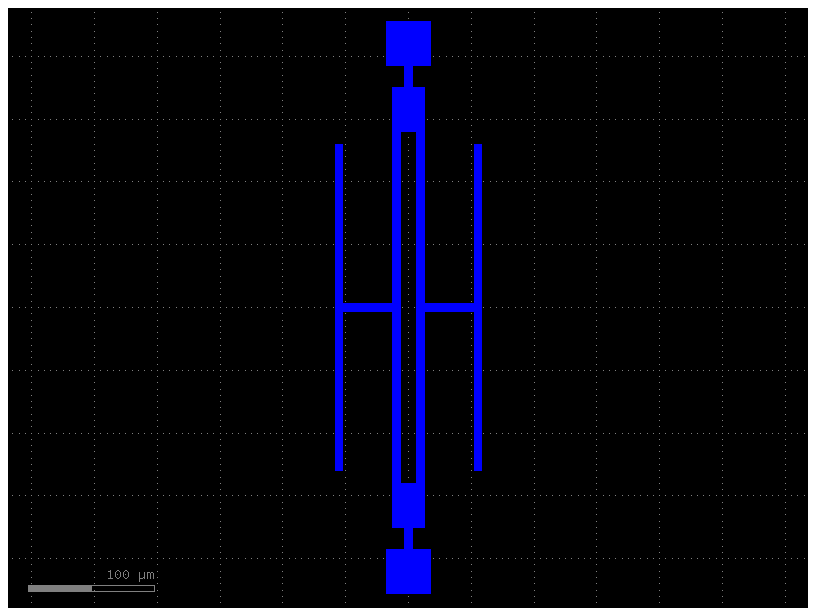

In [ ]:
from dataclasses import dataclass
from shapely.geometry.polygon import Polygon
from shapely.affinity import scale

# detf dimensions dataclass
@dataclass
class DimensionsDETF:
    beam_l: float # beam length (y-axis)
    fork_w: float # tuning fork width (x-axis)
    beam_t: float # beam thickness
    elec_l: float # drive electrode length (y-axis)
    elec_arm_w: float # drive electrode arm width (x-axis)

def detf(dim, layer):
    c = gf.Component("detf")

    # tuning fork prong
    rect0 = Polygon([(-dim.fork_w/2, -dim.beam_l/2), (-dim.fork_w/2, dim.beam_l/2), (dim.fork_w/2, dim.beam_l/2), (dim.fork_w/2, -dim.beam_l/2)])
    rect1 = Polygon([(-dim.fork_w/2+dim.beam_t, -dim.beam_l/2+dim.beam_t), (-dim.fork_w/2+dim.beam_t, dim.beam_l/2-dim.beam_t), (dim.fork_w/2-dim.beam_t, dim.beam_l/2-dim.beam_t), (dim.fork_w/2-dim.beam_t, -dim.beam_l/2+dim.beam_t)])

    rect0not1 = rect0 - rect1
    c.add_polygon(rect0not1, layer=layer)

    # prong base
    base_length = 0.1*dim.beam_l
    base_rect = Polygon([(-dim.fork_w/2, -dim.beam_l/2),(dim.fork_w/2, -dim.beam_l/2),(dim.fork_w/2, -dim.beam_l/2+base_length),(-dim.fork_w/2, -dim.beam_l/2+base_length)])
    base_rect_mirr = scale(base_rect, xfact=1, yfact=-1, origin=(0, 0)) # mirrored
    c.add_polygon(base_rect.union(base_rect_mirr), layer=layer)

    # anchor and link
    link_length = 0.05*dim.beam_l
    link_rect = Polygon([(-dim.beam_t/2, -dim.beam_l/2),(dim.beam_t/2, -dim.beam_l/2),(dim.beam_t/2, -dim.beam_l/2-link_length),((-dim.beam_t/2, -dim.beam_l/2-link_length))])
    link_rect_mirr = scale(link_rect, xfact=1, yfact=-1, origin=(0, 0)) # mirrored
    anchor_edge = 0.1*dim.beam_l
    anchor_rect = Polygon([(-anchor_edge/2, -dim.beam_l/2-link_length),(anchor_edge/2, -dim.beam_l/2-link_length),(anchor_edge/2, -dim.beam_l/2-link_length-anchor_edge),(-anchor_edge/2, -dim.beam_l/2-link_length-anchor_edge)])
    anchor_rect_mirr = scale(anchor_rect, xfact=1, yfact=-1, origin=(0, 0)) # mirrored
    c.add_polygon(link_rect.union(link_rect_mirr), layer=layer)
    c.add_polygon(anchor_rect.union(anchor_rect_mirr), layer=layer)

    # drive electrode arm
    drive_elec_arm = Polygon([(-dim.fork_w/2, -dim.beam_t/2),(-dim.fork_w/2, dim.beam_t/2),(-dim.fork_w/2-dim.elec_arm_w, dim.beam_t/2),(-dim.fork_w/2-dim.elec_arm_w, -dim.beam_t/2)])
    drive_elec_arm_mirr = scale(drive_elec_arm, xfact=-1, yfact=1, origin=(0, 0)) # mirrored
    c.add_polygon(drive_elec_arm.union(drive_elec_arm_mirr), layer=layer)

    # drive electrode
    drive_elec_origin = -dim.fork_w/2-dim.elec_arm_w
    drive_elec = Polygon([(drive_elec_origin,-dim.elec_l/2),(drive_elec_origin, dim.elec_l/2),(drive_elec_origin-dim.beam_t, dim.elec_l/2),(drive_elec_origin-dim.beam_t, -dim.elec_l/2)])
    drive_elec_mirr = scale(drive_elec, xfact=-1, yfact=1, origin=(0,0)) # mirrored
    c.add_polygon(drive_elec.union(drive_elec_mirr), layer=layer)

    return c

# dimensions in µm
dim_detf = DimensionsDETF(
    beam_l=350,
    fork_w=25,
    beam_t=6,
    elec_l=260,
    elec_arm_w=40,
)

detf_c = detf(dim_detf, biomems_pdk.layers['coating'])
detf_c.plot()

Now, let's duplicate it and create the drive electrode structures (where the varying voltage from the control loop is applied), fixed in the silicon.

In [ ]:
@dataclass
class DimensionsOuterDriveElec:
    l: float # drive electrode length (y-axis)
    w: float # drive electrode width (x-axis)

def outer_drive_electrode(dim, layer):
    c = gf.Component("drive_electrode")

    drive_elec_fixed = Polygon([(-dim.w/2, -dim.l/2),(-dim.w/2, dim.l/2),(dim.w/2, dim.l/2),(dim.w/2, -dim.l/2)])
    c.add_polygon(drive_elec_fixed, layer=layer)

    return c

@dataclass
class DimensionsInnerElec:
    vert_l: float # electrode vertical length
    hor_l: float # electrode horizontal length
    cont_w: float # contact width
    cont_h: float # contact height
    t: float # electrode prong thickness

def inner_electrode(dim, layer):
    c = gf.Component("inner_electrode")

    elec_beam = Polygon([(0, 0),(dim.t, 0),(dim.t, dim.vert_l),(0, dim.vert_l)])
    hor_beam = Polygon([(0, dim.vert_l),(dim.hor_l, dim.vert_l),(dim.hor_l, dim.vert_l-dim.t),(0, dim.vert_l-dim.t)])
    contact_rect = Polygon([(dim.hor_l, dim.vert_l),(dim.hor_l-dim.cont_w, dim.vert_l),(dim.hor_l-dim.cont_w, dim.vert_l+dim.cont_h),(dim.hor_l, dim.vert_l+dim.cont_h)])

    c.add_polygon(elec_beam, layer=layer)
    c.add_polygon(hor_beam, layer=layer)
    c.add_polygon(contact_rect, layer=layer)

    return c

# dimensions in µm
dim_drive_elec = DimensionsOuterDriveElec(
    l=260,
    w=40,
)
drive_elec_c = outer_drive_electrode(dim_drive_elec, biomems_pdk.layers['coating'])

# dimensions in µm
dim_inner_drive_elec = DimensionsInnerElec(
    vert_l = 150,
    hor_l = 60,
    cont_w = 60,
    cont_h = 60,
    t = 12,
)
inner_drive_elec_c = inner_electrode(dim_inner_drive_elec, biomems_pdk.layers['coating'])

Lastly, let's define the sense electrodes, used to detect the position of the resonator through a *motional current*. This current gets generated when the distance between the sense electrode and the resonator changes, which in turn varies the capacitance between these structures.

In [ ]:
# dimensions in µm
dim_sense_elec = DimensionsInnerElec(
    vert_l = 150,
    hor_l = 85,
    cont_w = 50,
    cont_h = 60,
    t = 6,
)
sense_elec_c = inner_electrode(dim_sense_elec, biomems_pdk.layers['coating'])

Merging these building blocks, the final mechanical structure with all electrodes can be drawn:

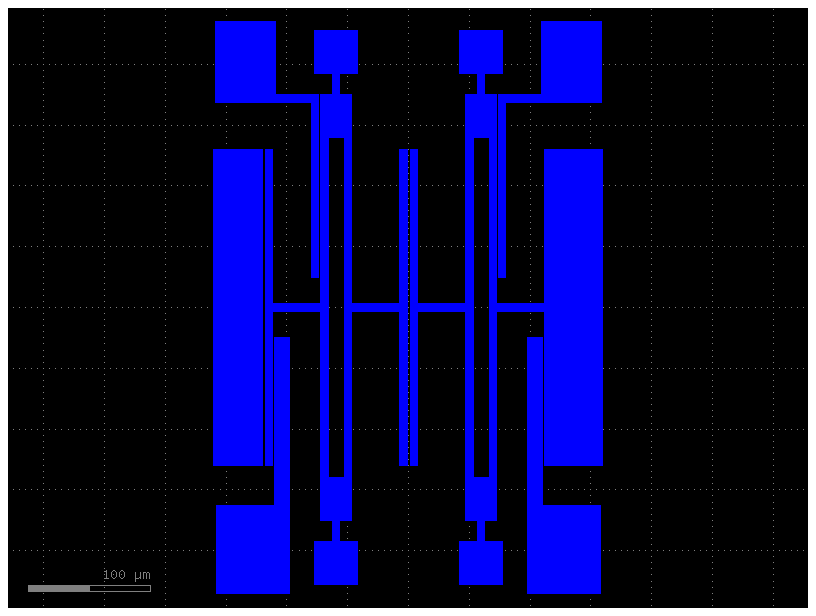

In [ ]:
def two_way_coupled_resonator(
    detf, dim_detf, coupling_gap,
    drive_elec, dim_drive_elec,
    inner_drive_elec, dim_inner_drive_elec,
    sense_elec, dim_sense_elec,
):
    electrode_gap = coupling_gap

    c = gf.Component("two_way_coupled_resonator")
    total_detf_length = dim_detf.fork_w + 2*dim_detf.elec_arm_w + 2*dim_detf.beam_t

    res1 = c.add_ref(detf)
    res2 = c.add_ref(detf)
    res1.move([-total_detf_length/2 - electrode_gap/2, 0])
    res2.move([total_detf_length/2 + electrode_gap/2 ,0])

    elec1 = c.add_ref(drive_elec)
    elec2 = c.add_ref(drive_elec)
    elec1.move([-total_detf_length - dim_drive_elec.w/2 - coupling_gap/2 - electrode_gap, 0])
    elec2.move([total_detf_length + dim_drive_elec.w/2 + coupling_gap/2 + electrode_gap, 0])

    sense_elec_pos_x = coupling_gap/2 + dim_detf.beam_t + dim_detf.elec_arm_w + dim_detf.fork_w + coupling_gap
    sense_elec_pos_y = dim_detf.beam_l/2 - dim_sense_elec.vert_l
    sense_elec1 = c.add_ref(sense_elec)
    sense_elec2 = c.add_ref(sense_elec.mirror())
    sense_elec1.move([sense_elec_pos_x, sense_elec_pos_y])
    sense_elec2.move([-sense_elec_pos_x, sense_elec_pos_y])

    inner_elec_pos_x = coupling_gap/2 + dim_detf.beam_t + 2*dim_detf.elec_arm_w + dim_detf.fork_w - dim_inner_drive_elec.t - coupling_gap
    inner_elec_pos_y = dim_detf.beam_l/2 - dim_sense_elec.vert_l
    inner_elec1 = c.add_ref(inner_drive_elec)
    inner_elec2 = c.add_ref(inner_drive_elec)
    inner_elec1.mirror_y()
    inner_elec2.mirror()
    inner_elec2.mirror_y()
    inner_elec1.move([inner_elec_pos_x, -inner_elec_pos_y])
    inner_elec2.move([-inner_elec_pos_x, -inner_elec_pos_y])

    return c

two_way_coupled_resonator(detf_c, dim_detf, 2, drive_elec_c, dim_drive_elec, inner_drive_elec_c, dim_inner_drive_elec, sense_elec_c, dim_sense_elec).plot()

*Disclaimer: some dimensions (especially small gaps) may seem off in the plot, but in the actual .gds they are correct*

And finally, to get the GDS of our MEMS design, because of our chosen manufacturing strategy, we must draw structures for all layers from the silicon substrate up to metal #5:

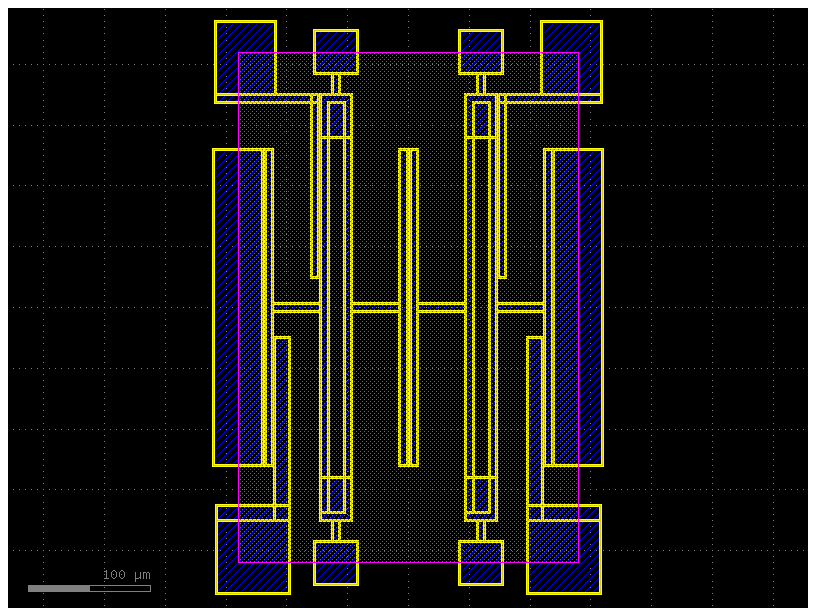

In [ ]:
mems_layers = ['li1drawing', 'licon1drawing', 'mcondrawing', 'met1drawing', 'viadrawing', 'met2drawing', 'via2drawing', 'met3drawing', 'via3drawing',
               'met4drawing', 'via4drawing', 'met5drawing']

coupling_gap = 2

# create CMOS process layers
coupled_resonators = gf.Component("coupled_resonators_all_layers")
for layer in mems_layers:
    resonator = detf(dim_detf, biomems_pdk.layers[layer])
    drive_elec = outer_drive_electrode(dim_drive_elec, biomems_pdk.layers[layer])
    inner_drive_elec = inner_electrode(dim_inner_drive_elec, biomems_pdk.layers[layer])
    sense_elec = inner_electrode(dim_sense_elec, biomems_pdk.layers[layer])

    coupled_resonators.add_ref(
        two_way_coupled_resonator(resonator, dim_detf, coupling_gap, drive_elec, dim_drive_elec, inner_drive_elec, dim_inner_drive_elec, sense_elec, dim_sense_elec)
    )

# create silicon subtrate trench
total_detf_length = dim_detf.fork_w + 2*dim_detf.elec_arm_w + 2*dim_detf.beam_t
total_two_way_detf_x = 2*total_detf_length + coupling_gap
total_two_way_detf_y = dim_detf.beam_l + 2*(0.05*dim_detf.beam_l + 0.1*dim_detf.beam_l)
trench_x = total_two_way_detf_x + 2*coupling_gap + dim_drive_elec.w
trench_y = total_two_way_detf_y - 0.1*dim_detf.beam_l

trench_rect = gf.components.rectangle(size=(trench_x, trench_y), layer=biomems_pdk.layers['trench'])
trench_rect_ref = coupled_resonators.add_ref(trench_rect)
trench_rect_ref.move([-trench_x/2,-trench_y/2])

coupled_resonators.plot()

Finally, let's add the coating necessary to bind HER2 molecules in one of the resonators:

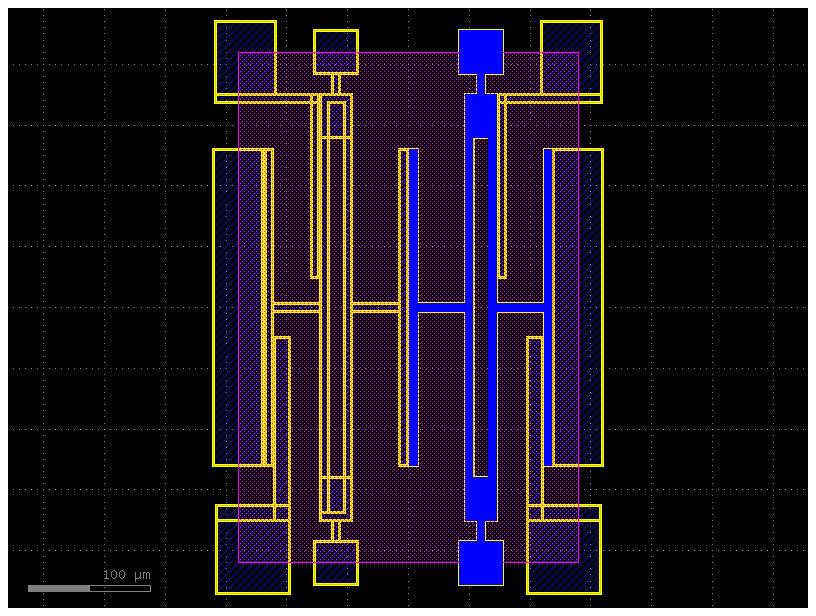

In [ ]:
res_coating = detf(dim_detf, biomems_pdk.layers['coating'])
res_coating_ref = coupled_resonators.add_ref(res_coating)
res_coating_ref.move([total_detf_length/2 + coupling_gap/2 ,0])

coupled_resonators.plot()

And finish by saving the GDSII file.

In [ ]:
coupled_resonators.write_gds("coupled_resonators.gds")

2023-12-03 18:19:36.023 | INFO     | gdsfactory.component:_write_library:1913 - Wrote to 'coupled_resonators.gds'


PosixPath('coupled_resonators.gds')

### Step 3: Simulating the mechanical microsystem

For the mechanical implementation, it'll be used Finite Element and the calculations will be made with the library OS FeniCS.  
The problem is defined as following by the constitutive equation and the boundary conditions:
\begin{equation}
\begin{cases}
\rho \ddot{\overline{u}} = div \ \overline{\overline{\sigma}} \ in \ \Omega \\
\overline{\overline{\sigma}} \cdot (-i) = \frac{Fel_{ext}}{S_{lateral}} \ in \ x=-8.5 \\
\overline{\overline{\sigma}} \cdot (-i) = \frac{F_{fluid}}{S_{lateral}} \ in \ x=-8.5 \\
\overline{\overline{\sigma}} \cdot  i = \frac{Fel_{mid}}{S_{mid}} \ in \ x=-7.5 \\
\overline{\overline{\sigma}} \cdot  i = \frac{Fel_{int}}{S_{int}} \ in \ x=-2.5 \\
\overline{\overline{\sigma}} \cdot  i = \frac{F_{coupling}}{S_{lateral}} \ in \ x=8.5 \\
\overline{\overline{\sigma}} \cdot i = \frac{F_{fluid}}{S_{lateral}} \ in \ x=-8.5 \ and \ x=8.5 \\
\overline{u}(x,20) = 0, \overline{u}(x,-20) = 0 \ \forall x
\end{cases}
\end{equation}
The eletrical force and the force of coupling are linearized for the FEM implementation. So they have the following expressions:
\begin{equation}
\begin{cases}
Fel_{ext} = \epsilon_{0}\frac{S_{lateral}}{G^{3}}(V_{res} - V_{ext})^2u_{x}^{1} - \epsilon_{0}\frac{S_{lateral}}{G^{2}}(V_{res} - V_{ext})^2 \\
Fel_{mid} = \epsilon_{0}\frac{S_{mid}}{G^{3}}(V_{res} - V_{mid})^2u_{x}^{1} - \epsilon_{0}\frac{S_{mid}}{G^{2}}(V_{res} - V_{mid})^2 \\
Fel_{int} = \epsilon_{0}\frac{3S_{int}}{4G^{3}}(V_{res} - V_{int})^2u_{x}^{1} - \epsilon_{0}\frac{3S_{int}}{4G^{2}}(V_{res} - V_{int})^2 \\
Fel_{coupling} = \epsilon_{0}\frac{S_{lateral}}{d^{3}}(V_{dc})^2(u_{x}^{1}-u_{x}^{2}) + \epsilon_{0}\frac{S_{lateral}}{2d^{2}}(V_{dc})^2
\end{cases}
\end{equation}
For the Fluid Force, it's proportional to $\dot{\overline{u}}$, so it does not affect the eigenfrequencies, it adds damping to the problem.

For the Finite Element implementation, first it's necessary to define the mechanics constitutive equations for a linear elastic model, which are:
\begin{equation}
\begin{cases}
\overline{\overline{\epsilon}} = \frac{1}{2}(\nabla\overline{u} + (\nabla\overline{u})^{T}) \\
\overline{\overline{\sigma}} = \lambda \ tr(\overline{\overline{\epsilon}})I + 2\mu\overline{\overline{\epsilon}}
\end{cases}
\end{equation}

Now it can be found the weak formulation to be implemented, it's defined a test function $v$, such that $v \in V$, the vector space that obeys the equations of the problem defined before. \\
The following arrives:
\begin{equation}
∫_{\Omega} \rho \ddot{\overline{u}} \ v \ dx = ∫_{\Omega} div \ \overline{\overline{\sigma}} \ v \ dx \\
∫_{\Omega} \rho \ddot{\overline{u}} \ v \ dx = ∫_{\partial \Omega}  (\overline{\overline{\sigma}} \cdot n)  \ v \ dx - ∫_{\Omega} \overline{\overline{\sigma}}: \ \epsilon(v) \ dx\\
∫_{\Omega} \rho \ddot{\overline{u}} \ v \ dx + ∫_{\Omega} \overline{\overline{\sigma}}(\overline{u}): \ \epsilon(v) \ dx\\ = ∫_{x=-8.5} \frac{Fel_{ext}}{S_{lateral}} v \ dx + ∫_{x=-7.5} \frac{Fel_{mid}}{S_{mid}} v \ dx + ∫_{x=-2.5} \frac{Fel_{int}}{S_{int}} v \ dx + ∫_{x=8.5} \frac{Fel_{coupling}}{S_{lateral}} v \ dx + ∫_{x=-8.5} \frac{Fel_{fluid}}{S_{lateral}} v \ dx + ∫_{x=8.5} \frac{Fel_{fluid}}{S_{lateral}} v \ dx
\end{equation}

To solve for the eigenfrequencies it's necessary to define the mass and stiffness matrix, for this it will be created and assembled 4 dimension vector with displacement in ressonator 1 and displacement in ressonator 2, with the same geometric as the first defined here and symmetric boundary conditions.

The matrix M will be defined as:

\begin{bmatrix}
M_{1} & 0 \\
0 & M_{2}  
\end{bmatrix}

Where the terms $M_{1}$ and $M_{2}$ will come from the bilinear form: $∫_{\Omega} \rho \ddot{\overline{u}} \ v \ dx$.

The matrix K will be defined as:
\begin{bmatrix}
K_{1} + K_{el1} + K_{c} & -K_{c} \\
-K_{c} & K_{2} + K_{el2} + K_{c}  
\end{bmatrix}

The term $K_{1}$ and $K_{2}$ come from the bilinear form $∫_{\Omega} \overline{\overline{\sigma}}(\overline{u}): \ \epsilon(v) \ dx$. The terms $K_{el1}$ and $K_{el2}$ come from the linear term of the $Fel_{ext}$, $Fel_{mid}$ and $Fel_{int}$. And for the $K_{c}$ term, it comes from the $Fel_{coupling}$ term. The term  $F_{fluid}$ is not considered for the matrices because it's proportional to $\dot{\overline{u}}$, so it's a damping term.

To find the eigenfrequencies it's considered that $\overline{u} = \overline{u_{0}} e^{i\omega t} $, and in the end the problem is resumed in solving: $det(K-\omega^{2}M)$.

In [ ]:
# global constants
MESH_RESOLUTION = 100
DATA_DIRECTORY  = "./data/"
PLOT_IMAGE      = False

In [ ]:
# auxiliary functions
def create_rectangle(center, width, height):
    """
    Creates a rectangle based on the center and the specified dimensions.

    Parameters:
    center (tuple): Center of the rectangle (x, y).
    width (float): Width of the rectangle.
    height (float): Height of the rectangle.

    Returns:
    Rectangle: Rectangle object from mshr.
    """
    bottom_left = (center[0] - width / 2, center[1] - height / 2)
    top_right   = (center[0] + width / 2, center[1] + height / 2)
    return Rectangle(Point(bottom_left[0], bottom_left[1]), Point(top_right[0], top_right[1]))

# Building the Geometry and Mesh

This notebook focuses on building the geometry of the MEMS device, including the main body, anchors, connectors and plates. The corresponding mesh will also be generated here.

In [ ]:
# defining dimensions
#T hree-dimensional thickness
thickness = 20.0e-6

# Main body dimensions
main_body_center = (0.0, 0.0)
main_body_external_width  = 5.0e-6
main_body_external_height = 40.0e-6
main_body_internal_width  = 3.0e-6
main_body_internal_height = 38.0e-6

# Anchors dimensions
anchor_width  = 3.0e-6
anchor_height = 3.0e-6
anchor_upper_center = (0, main_body_external_height / 2 + anchor_height / 2)
anchor_lower_center = (0, -main_body_external_height / 2 - anchor_height / 2)

# Connectors dimensions
connector_width   = 5.0e-6
connector_height  = 1.0e-6
connector_right_center  = (main_body_external_width / 2 + connector_width / 2, 0)
connector_left_center   = (-main_body_external_width / 2 - connector_width / 2, 0)

# Plates dimensions
plate_width   = 1.0e-6
plate_height  = 20.0e-6
plate_right_center  = (main_body_external_width / 2 + connector_width + plate_width / 2, 0)
plate_left_center   = (-main_body_external_width / 2 - connector_width - plate_width / 2, 0)

In [ ]:
# Create the main body
main_external_body = create_rectangle(main_body_center, main_body_external_width, main_body_external_height)
main_internal_body = create_rectangle(main_body_center, main_body_internal_width, main_body_internal_height)
main_body = main_external_body - main_internal_body

# Create anchors
anchor_upper = create_rectangle(anchor_upper_center, anchor_width, anchor_height)
anchor_lower = create_rectangle(anchor_lower_center, anchor_width, anchor_height)

# Create connectors
connector_right = create_rectangle(connector_right_center, connector_width, connector_height)
connector_left  = create_rectangle(connector_left_center, connector_width, connector_height)

# Create plates
plate_right = create_rectangle(plate_right_center, plate_width, plate_height)
plate_left  = create_rectangle(plate_left_center, plate_width, plate_height)

In [ ]:
complete_geometry = main_body + anchor_upper + anchor_lower + connector_right + connector_left + plate_right + plate_left

In [ ]:
# Mesh gen and visualization
def generate_and_save_mesh(geometry, resolution, filename, data_directory = DATA_DIRECTORY):
    """
    Generates a mesh from a geometry and saves it in an XML file.

    Parameters:
    geometry: Geometry to generate the mesh.
    resolution: Mesh resolution.
    filename: File name for saving the mesh.
    """
    mesh = generate_mesh(geometry, resolution)
    File(data_directory + filename) << mesh
    return mesh

def plot_and_save_mesh(mesh, file_name, data_directory = DATA_DIRECTORY, size=(25, 25), resolution=500):
    """
    Plots the mesh and saves the image to a file.

    Parameters:
    mesh: Mesh to plot.
    filename: File name for saving the image.
    size: Size of the picture (width, height).
    """
    plt.figure(fig_size=size)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_facecolor('white')
    plot(mesh, "2D Mesh", color='black', linewidth=0.05)
    plt.grid(True, which='both', color='lightgray', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(5))
    plt.gca().xaxis.set_minor_locator(ticker.MultipleLocator(1))
    plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(1))
    plt.title("2-DoF DETF Resonator MEMS")
    plt.xlabel("μm")
    plt.ylabel("μm")
    plt.savefig(data_directory + file_name, dpi=resolution)
    plt.close()

  mesh = generate_and_save_mesh(complete_geometry, MESH_RESOLUTION, "mems_mesh.xml")
if PLOT_IMAGE:
  plot_and_save_mesh(mesh, "2-DoF-DETF-Resonator.png")

# Definition of Subdomains and Formulation of Equations

In this notebook, we will define the subdomains of the MEMS problem and the related equations, including relevant constants and variables, as well as the epsilon and sigma functions.

In [ ]:
class Left_Plate_Ext_Electrode(SubDomain):
 def inside(self, x, on_boundary):
  return near(x[0], -main_body_external_width / 2 - connector_width - plate_width)

class Left_Plate_Mid_Electrode(SubDomain):
 def inside(self, x, on_boundary):
  return near(x[0], -main_body_external_width/2 - connector_width) and x[1] < -connector_height / 2

class Left_Plate_Int_Electrode(SubDomain):
 def inside(self, x, on_boundary):
  return near(x[0], -main_body_external_width / 2) and x[1] > connector_height / 2

class Right_Plate_Ext_Electrode(SubDomain):
 def inside(self, x, on_boundary):
  return near(x[0], main_body_external_width / 2 + connector_width + plate_width)

class Right_Plate_Mid_Electrode(SubDomain):
 def inside(self, x, on_boundary):
  return near(x[0], main_body_external_width / 2 + connector_width) and x[1] < -connector_height / 2

class Right_Plate_Int_Electrode(SubDomain):
 def inside(self, x, on_boundary):
  return near(x[0], main_body_external_width / 2) and x[1] > connector_height / 2

# subdomains
sub_domains = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
sub_domains.set_all(6)

left_plate_ext_electrode = Left_Plate_Ext_Electrode()
left_plate_ext_electrode.mark(sub_domains,0)

left_plate_mid_electrode = Left_Plate_Mid_Electrode()
left_plate_mid_electrode.mark(sub_domains,1)

left_plate_int_electrode = Left_Plate_Int_Electrode()
left_plate_int_electrode.mark(sub_domains,2)

right_plate_ext_electrode = Right_Plate_Ext_Electrode()
right_plate_ext_electrode.mark(sub_domains,3)

right_plate_mid_electrode = Right_Plate_Mid_Electrode()
right_plate_mid_electrode.mark(sub_domains,4)

right_plate_int_electrode = Right_Plate_Int_Electrode()
right_plate_int_electrode.mark(sub_domains,5)

In [ ]:
# Physical constants
LMBDA_1     = 5.152e10 #[Pa]
MU_1        = 6.557e10 #[Pa]
LMBDA_2     = LMBDA_1 #[Pa]
MU_2        = MU_1 #[Pa]
EPSILON_0   = 8.854e-12 #[C² / N.m²]
RHO_1       = 2330.0 #[Kg / x³]
RHO_2       = 2330.0 #[Kg / x³]

In [ ]:
# Geometric params and distances
main_body_external_area     = main_body_external_height * thickness  #[m²]
resonator_gap_distance      = 0.3e-6  #[m]
plate_surface_area          = plate_height * thickness  #[m²]
central_plate_gap_distance  = 0.3e-6  #[m]

In [ ]:
# Voltages
Vextl   = 0.0 #[Volts]
Vextr   = 0.0 #[Volts]
Vintl   = 1.0 #[Volts]
Vintr   = -Vintl #[Volts]
Vres    = 50.0 #[Volts]
Vmidl   = Vres #[Volts]
Vmidr   = Vres #[Volts]
Vdc     = 1.0 #[Volts]

In [ ]:
# Electrostatic forces and coupling calculation
# Constants for electrostatic force calculations
## First resonator
alpha1_1 = thickness * EPSILON_0 / (2 * resonator_gap_distance ** 3) * (2 * (Vres - Vextl) ** 2)
alpha1_2 = (EPSILON_0 * thickness / (2 * resonator_gap_distance ** 3)) * 2 * (Vres - Vmidl) ** 2
alpha1_3 = (EPSILON_0 * thickness / (2 * resonator_gap_distance ** 3)) * 1.5 * 0.523 * (main_body_external_area / plate_surface_area) * (Vres - Vintl) ** 2

## Second resonator
alpha2_1 = thickness * EPSILON_0 / (2 * resonator_gap_distance ** 3) * (2 * (Vres - Vextr) ** 2)
alpha2_2 = (EPSILON_0 * thickness / (2 * resonator_gap_distance ** 3)) * 2 * (Vres - Vmidr) ** 2
alpha2_3 = (EPSILON_0 * plate_surface_area / (2 * resonator_gap_distance ** 3)) * 1.5 * 0.523 * (main_body_external_area / plate_surface_area) * (Vres - Vintr) ** 2

# Coupling force constant
F_coupl = thickness * (Vdc ** 2) * EPSILON_0 / (central_plate_gap_distance ** 3)

In [ ]:
# Functions for epsilon and sigma
def epsilon(u):
    return sym(grad(u))

def sigma(u):
    dim = u.geometric_dimension()
    return LMBDA_1 * tr(epsilon(u)) * Identity(dim) + 2 * MU_1 * epsilon(u)

# Boundary conditions
def upper_anchor_boundary(x, on_boundary):
    return near(x[1], (main_body_external_height / 2) + anchor_height) and on_boundary

def lower_anchor_boundary(x, on_boundary):
    return near(x[1], -(main_body_external_height / 2) - anchor_height) and on_boundary

# Weak Formulation and Problem Solving

This notebook focuses on the weak formulation of the MEMS problem and the configuration of the eigenvalue solver to find the natural frequencies of the system.

## Definition of Function Space and Test/Trial Functions

In [ ]:
V = VectorFunctionSpace(mesh, "CG", 2)

u_tr_1      = TrialFunction(V)
u_test_1    = TestFunction(V)

u_tr_2      = TrialFunction(V)
u_test_2    = TestFunction(V)

In [ ]:
# Boundary conditions
bc1_1 = DirichletBC(V, Constant((0, 0)), upper_anchor_boundary)
bc1_2 = DirichletBC(V, Constant((0, 0)), lower_anchor_boundary)
bc = [bc1_1, bc1_2]

# Spliting vectors
u_tr_1_1, u_tr_1_2      = split(u_tr_1)
u_tr_2_1, u_tr_2_2      = split(u_tr_2)
u_test_1_1, u_test_1_2  = split(u_test_1)
u_test_2_1, u_test_2_2  = split(u_test_2)

# Definition of weak formulation
# Surface measure for subdomains
ds = Measure('ds', domain=mesh, subdomain_data=sub_domains)

def assemble_mass_matrix(u_trial, u_test, density):
    return density * inner(u_trial, u_test) * dx

def assemble_stiffness_matrix(u_trial, u_test):
    return inner(sigma(u_trial), epsilon(u_test)) * dx

def coupling_term(u_trial, u_test, subdomain_index):
    return F_coupl * u_trial * u_test * ds(subdomain_index)

def electrostatic_force(u_trial, u_test, alpha, subdomain_index):
    return -alpha * u_trial * u_test * ds(subdomain_index)

# Assembling the mass and stiffness matrices
m = assemble_mass_matrix(u_tr_1, u_test_1, RHO_1) + assemble_mass_matrix(u_tr_2, u_test_2, RHO_2)
k = assemble_stiffness_matrix(u_tr_1, u_test_1) + assemble_stiffness_matrix(u_tr_2, u_test_2)

# Assembling the electrostatic force term
l = (coupling_term(u_tr_1_1, u_test_1_1, 3) + electrostatic_force(u_tr_1_1, u_test_1_1, alpha1_1, 0)
     + electrostatic_force(u_tr_1_1, u_test_1_1, alpha1_2, 1) + electrostatic_force(u_tr_1_1, u_test_1_1, alpha1_3, 2)
     - coupling_term(u_tr_2_1, u_test_1_1, 3) + coupling_term(u_tr_2_1, u_test_2_1, 0)
     - coupling_term(u_tr_1_1, u_test_2_1, 0) + electrostatic_force(u_tr_2_1, u_test_2_1, alpha2_1, 3)
     - electrostatic_force(u_tr_2_1, u_test_2_1, alpha2_2, 4) + electrostatic_force(u_tr_2_1, u_test_2_1, alpha2_3, 5))

In [ ]:
# Setting up and applying boundary conditions
K = PETScMatrix()
M = PETScMatrix()

K = assemble(k + l, tensor=K)
M = assemble(m, tensor=M)

for bc in [bc1_1, bc1_2]:
    bc.apply(K)
    bc.apply(M)

## Configuring the Eigenvalue Solver

In [ ]:
PETScOptions.set("eps_view")
eigensolver = SLEPcEigenSolver(K, M)

eigensolver.parameters['problem_type']  = "gen_hermitian"
eigensolver.parameters["spectrum"]      = "smallest magnitude"

# Solving the Eigenvalue Problem and Visualizing Modes

In this notebook, we solve the eigenvalue problem to find the natural frequencies of the system and visualize the corresponding modes.

In [ ]:
PETScOptions.set("eps_view")
eigensolver = SLEPcEigenSolver(K, M)

eigensolver.parameters['problem_type'] = "gen_hermitian"
eigensolver.parameters["spectrum"] = "smallest magnitude"

number_eigen_values = 100

eigensolver.solve(number_eigen_values)

file_results = XDMFFile("MA.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

min_frequency = None

for index in range(number_eigen_values):
    # Get the pair of eigenvalues (real and imaginary part)
    try:
      r, c, rx, cx = eigensolver.get_eigenpair(index)

      # Calculate the natural angular frequency omega from the real part of the eigenvalue
      omega = np.sqrt(abs(r))

      # Calculate the natural frequency f from omega
      frequency = omega/2/pi

      if min_frequency is None or frequency < min_frequency:
            min_frequency = frequency

      # Display the results
      print("----------------------------------------------------")
      print(f'Eigenvalue {index}:')
      print(f'    Real part: {r}')
      print(f'    Imaginary part: {c}')
      print(f'    Angular frequency (omega): {omega} rad/s')
      print(f'    Frequency: {frequency} Hz')


      # Initialize function and assign eigenvector
      eigenmode = Function(V, name="Eigenvector " + str(index))
      eigenmode.vector()[:] = rx

      # Write i-th eigenfunction to xdmf file
      file_results.write(eigenmode, index)
    except:
      break

print(f"## Min. Frequency: {min_frequency:.3f} [Hz]")

## Definition of Auxiliary Functions (Optionally)

In [ ]:
# Configure the eigenvalue solver
PETScOptions.set("eps_view")
eigensolver = SLEPcEigenSolver(K, M)
eigensolver.parameters['problem_type'] = "gen_hermitian"
eigensolver.parameters["spectrum"] = "smallest magnitude"

# Number of eigenvalues to be computed
number_eigen_values = 100

# Solve the eigenvalue problem
eigensolver.solve(number_eigen_values)

# Create file to save vibration modes
file_results = XDMFFile("MA.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

min_frequency = None

# Obtain the number of eigenvalues actually computed
computed_eigenvalues = eigensolver.get_number_converged()

# Iterate over the computed eigenvalues
for index in range(min(number_eigen_values, computed_eigenvalues)):
    r, c, rx, cx = eigensolver.get_eigenpair(index)
    omega = np.sqrt(abs(r))
    frequency = omega / (2 * np.pi)

    # Update the minimum frequency, if necessary
    if min_frequency is None or frequency < min_frequency:
        min_frequency = frequency

    # Display the results
    print(f"Eigenvalue {index}: Real part: {r}, Imaginary part: {c}, "
          f"Angular frequency (omega): {omega:.3f} rad/s, "
          f"Frequency: {frequency:.3f} Hz")

    # Initialize the function and assign the eigenvector
    eigenmode = Function(V, name=f"Eigenvector {index}")
    eigenmode.vector()[:] = rx

    # Write the i-th eigenfunction in the XDMF file
    file_results.write(eigenmode, index)

# Display the minimum frequency
if min_frequency is not None:
    print(f"## Minimum Frequency: {min_frequency:.3f} Hz")
else:
    print("No eigenvalues were computed.")

## Solving the Eigenvalue Problem and Calculating the Frequencies (Optionally)

In [ ]:
number_eigen_values = 100
eigenpairs    = solve_eigenproblem(eigensolver, number_eigen_values)
min_frequency = calculate_and_print_frequencies(eigenpairs)

## Saving Modes to File (Optionally)

In [ ]:
file_results = XDMFFile(DATA_DIRECTORY + "MA.xdmf")
file_results.parameters["flush_output"]         = True
file_results.parameters["functions_share_mesh"] = True

for index, (_, _, rx, _) in enumerate(eigenpairs):
    eigenmode = Function(V, name=f"Eigenvector {index}")
    eigenmode.vector()[:] = rx
    file_results.write(eigenmode, index)

Therefore, the resonant frequency of the balanced coupled system is **629257.625 Hz** for the desired mode. The electronic circuit must thus support that.

### Step 4: Designing the analog/digital front-end

#### General Description

The analog/digital front-end is essentially a series of cascading amplyfing stages used to amplify the differential signals near the resonance frequency of the MEMS device. The amplified signals are then compared to detect maximum and minimum levels according to the MEMS device position, and based on these values a small pulse is generated to drive the MEMS itself.

This circuit can be decomposed in the following stages, each with a particular function:

- Differential Amplifier: used to amplify the signal from the sense-mode electrodes of the MEMS device;
- High-Pass Filter: used to remove the output DC offset added by the preceding stage;
- Buffer: used to restore signal integrity;
- Non-Inverting Amplifier: used as a final gain stage;
- Comparator: used to compare the amplified signals and generate a digital output signal;
- Pulse Generator: used to generate the pulses that drive the MEMS resonator based on the rising and falling edges of the comparator.

#### Electrical Simulation

The AMS front-end was then simulated on the schematic level by separating the system into two different components:

- Analog: system composed from the input signals up to the output of the comparator;
- Mixed-Signal: pulse generator

This separation allows to better analyze the behaviour of each subsystem. We consider that the two main building blocks (avsd_opamp and avsd_cmp) were already characterized by their designers with proper specific simulations to each IP type,in the target PDK (SKY130). Therefore, transient simulations were chosen to simulate the system behaviour in this case. This analysis allows for direct visualization of the outputs in the time domain, thus being more suitable to observe the functionality of this circuit.

In line with the open-source purpose of this project, `ngspice` was used for all subsequent simulations.


##### **Analog System Simulation**

The analog subcircuit simulation .spice file is shown below.

In [ ]:
!mkdir sim/
!cp -r avsd_opamp/skywater_pdk ./skywater_pdk

mkdir: cannot create directory ‘sim/’: File exists


In [ ]:
%%writefile sim/transient.spice
* Transient simulation

.lib "../skywater_pdk/sky130_fd_pr/models/sky130.lib.spice" tt

* OpAmp circuit
.include avsd_opamp.cir

* Stage 1 - Differential amplifier
X1 vss vdd gnd in1 in2 out2 asvd_opamp
R1 in2 gnd 0.5Meg
R2 in1 out2 0.5Meg

* BVD model resistance (to emulate MEMS)
Rmems1 in1 inAC1 0.1Meg
Rmems2 in2 inAC2 0.1Meg

v1 vdd gnd dc 1.8
v2 vss gnd dc -1.8
v3 inAC1 gnd sine(0 1m 500k)
v4 inAC2 gnd sine(0 -1m 500k)

* High-pass filter
C1 out2 out3 10n
R3 out3 gnd 50k

* Buffer
X2 vss vdd gnd out4 out3 out4 asvd_opamp

* Stage 2 - Non-inverting amplifier
X3 vss vdd gnd in12 in22 out5 asvd_opamp
R4 in12 gnd 1k
R5 in12 out5 20.03k

* Noninv forced offset
R6 in22 out4 1.03k
R7 in22 inOff 20k

v5 inOff gnd 1.2

* Stage 3 - Comparator circuit

* Comparator circuit
.include avsd_cmp.cir

X4 vcc gnd en out6 inOff out5 net4 avsd_cmp

Ihyst vcc net4 0
v6 vcc gnd 3.3
v7 en gnd 3.3

*Simulation Command
.tran 0.1u 10u

* ngspice control statements
.control
run

*For Transient Analysis
* plot v(inAC1) v(inAC2) v(out2) ; diff amplifier
* plot v(out2) v(out3) v(out4) ; high-pass filter and buffer
* plot v(inOff) v(out4) v(out5) ; non-inv amplifier
* plot v(out5) v(inOff) v(out6) ; comparator
.endc

.end

Writing sim/transient.spice


The open-source IP models from their respective GitHub repos were slightly adapted to fit a subcircuit configuration in ngspice, and make it easier to instantiate them:

In [ ]:
# Comparator model
%%writefile sim/avsd_cmp.cir
.subckt avsd_cmp vcc gnd en vout inn inp net4

XM2 VDIFF net1 VCC VCC sky130_fd_pr__pfet_g5v0d10v5 L=1 W=1
XM1 net1 net1 VCC VCC sky130_fd_pr__pfet_g5v0d10v5 L=1 W=1
XM12 VOUT2 VOUT1 VCC VCC sky130_fd_pr__pfet_g5v0d10v5 L=0.5 W=4
XM10 VOUT1 VDIFF VCC VCC sky130_fd_pr__pfet_g5v0d10v5 L=0.5 W=6

XM16 VOUT VOUT2 VCC VCC sky130_fd_pr__pfet_g5v0d10v5 L=0.5 W=4
XM22 VOUT2 EN VCC VCC sky130_fd_pr__pfet_g5v0d10v5 L=0.5 W=4
XM20 VOUT VOUT2 GND GND sky130_fd_pr__nfet_g5v0d10v5 L=0.5 W=2
XM17 net5 EN GND GND sky130_fd_pr__nfet_g5v0d10v5 L=0.5 W=2
XM13 VOUT2 VOUT1 net5 GND sky130_fd_pr__nfet_g5v0d10v5 L=0.5 W=2
XM11 VOUT1 VCC GND GND sky130_fd_pr__nfet_g5v0d10v5 L=0.5 W=0.5
XM7 net3 net4 GND GND sky130_fd_pr__nfet_g5v0d10v5 L=0.5 W=0.5
XM18 net4 net4 GND GND sky130_fd_pr__nfet_g5v0d10v5 L=0.5 W=0.5
XM6 net1 VOUT2 net3 GND sky130_fd_pr__nfet_g5v0d10v5 L=0.5 W=2
XM8 VDIFF VOUT1 net3 GND sky130_fd_pr__nfet_g5v0d10v5 L=0.5 W=2
XM5 net2 VCC GND GND sky130_fd_pr__nfet_g5v0d10v5 L=1 W=0.5
XM3 net1 INN net2 GND sky130_fd_pr__nfet_g5v0d10v5 L=0.5 W=1
XM4 VDIFF INP net2 GND sky130_fd_pr__nfet_g5v0d10v5 L=0.5 W=1

xR1 vdd ref gnd sky130_fd_pr__res_high_po_0p69 l=100

.ends

Overwriting sim/avsd_cmp.cir


In [ ]:
# Opamp model
%%writefile sim/avsd_opamp.cir
.subckt asvd_opamp vss vdd gnd in1 in2 out2

* in1 = inverting input
* in2 = non-inverting input

* Stage 1 - Differential amplifier
xm1 net-_m1-pad1_ in1 net-_m1-pad3_ net-_m1-pad3_ sky130_fd_pr__nfet_01v8 l=1 w=1.79
xm2 out1 in2 net-_m1-pad3_ net-_m1-pad3_ sky130_fd_pr__nfet_01v8 l=1 w=1.79
xm3 net-_m1-pad1_ net-_m1-pad1_ vdd vdd sky130_fd_pr__pfet_01v8 l=1 w=10
xm4 out1 net-_m1-pad1_ vdd vdd sky130_fd_pr__pfet_01v8 l=1 w=10

* Current Mirror
xm5 net-_m1-pad3_ ref vss vss sky130_fd_pr__nfet_01v8 l=1 w=20
xm6 ref ref vss vss sky130_fd_pr__nfet_01v8 l=1 w=10

* Stage 2 - PMOS Common Source Amplifier
xm7 out2 out1 vdd vdd sky130_fd_pr__pfet_01v8 l=1 w=62.83
xm8 out2 ref vss vss sky130_fd_pr__nfet_01v8 l=1 w=62.83


* Circuit Bias
* v1  vdd gnd dc 1
* v2  vss gnd dc -1
xR1 vdd ref gnd sky130_fd_pr__res_high_po_0p69 l=100


* v3 in1 gnd sine(0 1m 60)
* v4 in2 gnd sine(0 -1m 60)

.ends

Overwriting sim/avsd_opamp.cir


In [48]:
# Run simulation
!cd sim/ && ngspice transient.spice

******
** ngspice-36 : Circuit level simulation program
** The U. C. Berkeley CAD Group
** Copyright 1985-1994, Regents of the University of California.
** Copyright 2001-2020, The ngspice team.
** Please get your ngspice manual from http://ngspice.sourceforge.net/docs.html
** Please file your bug-reports at http://ngspice.sourceforge.net/bugrep.html
** Creation Date: Sat Jan  1 18:54:42 UTC 2022
******
ERROR: (external)  no graphics interface;
 please check if X-server is running,
 or ngspice is compiled properly (see INSTALL)

No compatibility mode selected!


Circuit: * transient simulation

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
sky130_fd_pr__esd_nfet_05v0_nvt.pm3               0
                                             0
x1.net-_m1-pad1_                      0.370866
in1                               -0.00053047

KeyboardInterrupt: ignored

In the open-loop configuration, the input signals were considered to be two sinusoids of 1mV amplitude with 180 degrees phase shift. The nature of this signal is explained by the mechanical model of the MEMS resonator, and the frequency is taken as an approximation of the resonance frequency of this model. Moreover, the impedance of these signal sources is taken as 0.1MOhm as an approximation of the resistance of the MEMS device electrodes.

These signals (inAC1 and inAC2) are amplified by the differential amplifier, which generates the first output (out2). As shown by the simulation. One can see by the simulation that this yields a sinusoidal output at the same frequency with approximately 10mV amplitude (~10x gain), but with a DC offset of about -2.5mV, which justifies the need for a high pass filter.

![](https://github.com/luccareinehr/sscs-ose-code-a-chip.github.io/blob/main/ISSCC24/submitted_notebooks/sscs-cancer-biomems/img/sim-out-1.png?raw=true)

With the high-pass filter, the DC offset introduced by the differential amplifier (signal out2) is filtered out and transformed in a nearly pure sinusoid with the same amplitude (out3). This indicates that the cutoff frequency of the filter is properly designed.

Moreover, in this same plot, one can see that the buffer indeed generates an output signal (out4) which is nearly identical as its input (out3).


![](https://github.com/luccareinehr/sscs-ose-code-a-chip.github.io/blob/main/ISSCC24/submitted_notebooks/sscs-cancer-biomems/img/sim-out-2.jpg?raw=true)

The simulation also indicates that the final amplifying stage also works as expected. In this case, a DC bias voltage is added to the purely sinusoidal input signal (out4). This signal is then amplified and generates the output signal out5. One can see that this signal has a DC level of 1.2V with a superposed 200mV sinusoidal signal in phase with the input (non-inverting characteristic), thus with an added ~20x gain compared to the output of the differential amplifier.

Therefore, the cascaded configuration of the amplifying stages generate a voltage gain of approximately ~200x, with the 1mV input signal from the MEMS resonater turning into a 200mV signal that will be used as the input of the comparator.

![](https://github.com/luccareinehr/sscs-ose-code-a-chip.github.io/blob/main/ISSCC24/submitted_notebooks/sscs-cancer-biomems/img/sim-out-3.jpg?raw=true)

Finally, the comparator uses a voltage reference of 1.2V (DC level of the input signal) to compare to the sinusoidal 200mV input signal. One can see from transient simulations that the comparator indeed generates a rail-to-rail output signal with both rise/fall times and delays in the nanosecond range, which is sufficiently fast for this application.

![](https://github.com/luccareinehr/sscs-ose-code-a-chip.github.io/blob/main/ISSCC24/submitted_notebooks/sscs-cancer-biomems/img/sim-out-4.png?raw=true)

Therefore, the analog part of the circuit can generate a digital output comparison signal from the 1mV sensing signal from the MEMS resonator.


##### **Mixed-Signal Simulation**

The mixed-signal subcircuit simulation .spice file is shown below.

In [ ]:
%%writefile sim/transient_pulse.cir
* Transient simulation

.lib "../skywater_pdk/sky130_fd_pr/models/sky130.lib.spice" tt

* Pulsegen ckt
.include pulsegen.cir

v1 vdd gnd dc 3.3
v2 vss gnd dc 0
v3 in gnd pulse(0 3.3 0 30n 15n 1u 2u)

X1 vdd vss in outp outm pulsegen

C1 outp gnd 50ff
C2 outm gnd 50ff

*Simulation Command
.tran 0.05u 4u

* ngspice control statements
.control

run
* print v(in) v(outp) v(outm) > plot_data_v.txt
* print alli > plot_data_i.txt

* plot v(in) v(outp) v(outm)

.endc

.end

In [ ]:
# Run simulation
!cd sim/ && ngspice transient_pulse.spice

![](https://github.com/luccareinehr/sscs-ose-code-a-chip.github.io/blob/main/ISSCC24/submitted_notebooks/sscs-cancer-biomems/img/sim-dig-out.png?raw=true)

The mixed-signal part of the circuit, composed by the pulse generator, is also simulated with a transient analysis. For this case, the input signal is considered to be a pulse signal with the digital levels and a rise/fall time of approximately 10ns, which is a good initial approximation of the comparator output.

From this signal, one can see that the pulse generator can generate a short pulse both at the rising and falling edges of the input digital signal, with a pulse width of approximately 10ns.


### Step 5: Generating the front-end physical layout

With the circuit simulated in Spice using the models from SKY130, we usually proceed to its physical layout. Being a mixed-signal design, it's not trivial to automatically generate a physical layout since most open-source tools are aimed towards fully digital synthesis, such as OpenROAD. To make our physical layout generation step feasible, we've established the following strategy:

1. Generate a .gds and a .lef for each cell not present in SKY130
2. Create a top-down Verilog module describing the circuit
3. Run OpenROAD-Flow-Scripts

Cells not present in SKY130 include the open-source IPs (operational amplifiers and comparator), the resistors, the capacitors and the MEMS device. We can treat the MEMS device just like any other microelectronic cell, since it's basically an atypical GDS geometry with ports just like other cells; the OpenROAD router *should* detect it correctly. Because of its sizes, all of these components will be added as macros in the digital design flow.

Furthermore, for OpenROAD-Flow-Scripts, a custom PDN (power delivery network) script should be written to account for the two voltage domains (+-1.8V and GND for the analog stages, 3.3V and GND for the digital stages).


The original goal of our notebook was to show the feasibility of making a MEMS SoC design using open-source tools and IP. Because of the extent the notebook has already taken, and considering our goal and the goal of the competition to show design practices in open-source chip design, we've decided to spare the actual digital flow using OpenROAD from this project. Therefore, only step 1 of our strategy will be shown here, and steps 2 and 3 can be certainly be seen more thoroughly in other projects (such as [OpenFASOC](https://github.com/idea-fasoc/OpenFASOC), for example).

#### Generating .gds and .lef for each macro

For the open-source IPs, we can just copy the Magic (.mag) files from their repositories, and convert them to .gds and .lef:

In [ ]:
%%writefile magic_to_gds.sh

# Assign input .mag file to a variable
input_mag_file="$1"

# Extract the file name from input .mag
file_name=$(basename -- "$input_mag_file")
file_name_no_ext="${file_name%.*}"

# Open magic and convert to gds
conda-env/bin/magic -dnull -noconsole -T conda-env/share/pdk/sky130A/libs.tech/magic/sky130A.tech -rcfile conda-env/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc <<EOF
load $input_mag_file.mag
gds write $file_name_no_ext.gds
lef write $file_name_no_ext.lef
quit -noprompt
EOF

Writing magic_to_gds.sh


In [ ]:
%%shell
bash ./magic_to_gds.sh avsd_opamp/layout_design/avsd_opamp_layout.mag
bash ./magic_to_gds.sh avsdcmp_3v3_sky130/Layout/comparator.mag


Magic 8.3 revision 452 - Compiled on Tue Nov 28 23:18:17 UTC 2023.
Starting magic under Tcl interpreter
Using the terminal as the console.
Using NULL graphics device.
Input style sky130(): scaleFactor=2, multiplier=2
The following types are not handled by extraction and will be treated as non-electrical types:
    ubm 
Processing system .magicrc file
Sourcing design .magicrc for technology sky130A ...
2 Magic internal units = 1 Lambda
Loading sky130A Device Generator Menu ...
Using technology "sky130A", version 1.0.459-0-g369e64e
Cell avsd_opamp_layout read from path avsd_opamp/layout_design
Scaled magic input cell avsd_opamp_layout geometry by factor of 2
   Generating output for cell avsd_opamp_layout
Generating LEF output avsd_opamp_layout.lef for cell avsd_opamp_layout:
Diagnostic:  Write LEF header for cell avsd_opamp_layout
Diagnostic:  Writing LEF output for cell avsd_opamp_layout
Diagnostic:  Scale value is 0.005000

Magic 8.3 revision 452 - Compiled on Tue Nov 28 23:18:17 UTC

Ampop layout:

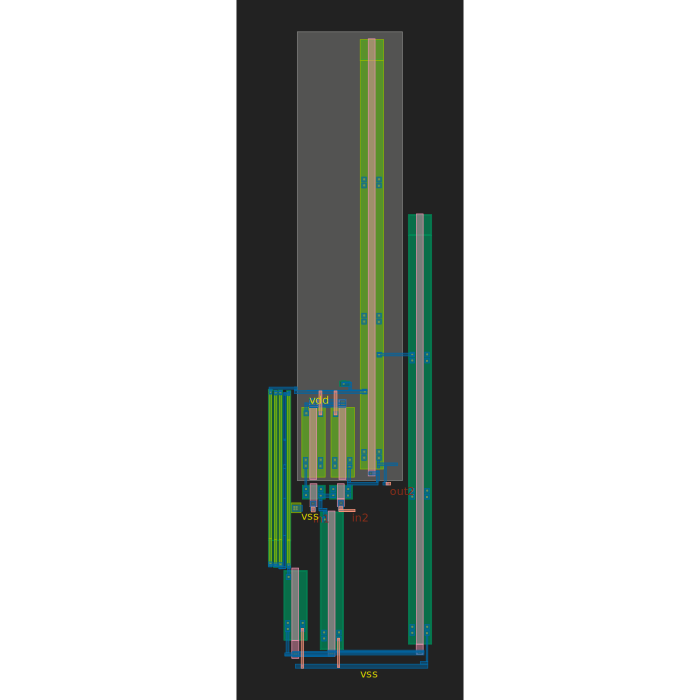

In [ ]:
import gdstk
import os
import IPython.display
import svgutils.transform as sg

flrpln = gdstk.read_gds("avsd_opamp_layout.gds")
flrpln_top_cell = flrpln.top_level()
flrpln_top_cell[0].write_svg('avsd_opamp_layout.svg')
fig = sg.fromfile('avsd_opamp_layout.svg')
fig.set_size(('700','700'))
fig.save('avsd_opamp_layout.svg')
IPython.display.SVG('avsd_opamp_layout.svg')

Comparator layout:

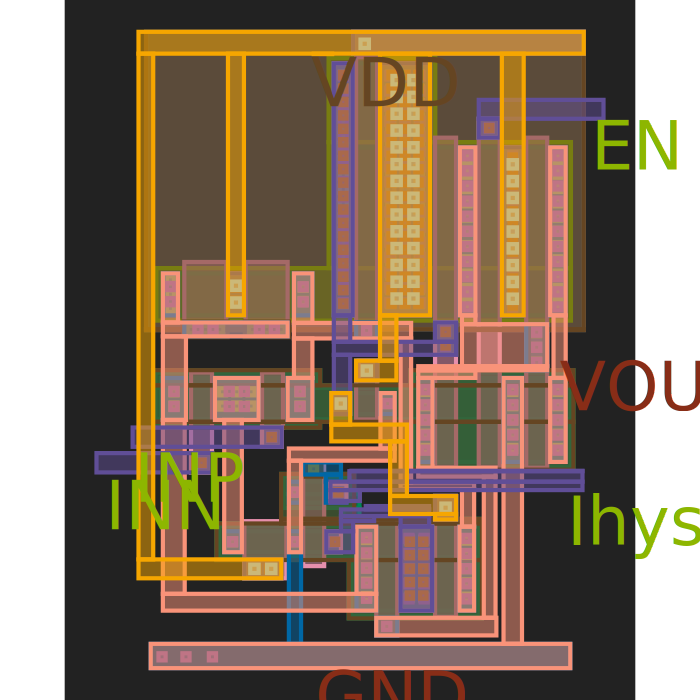

In [ ]:
flrpln = gdstk.read_gds("comparator.gds")
flrpln_top_cell = flrpln.top_level()
flrpln_top_cell[0].write_svg('comparator.svg')
fig = sg.fromfile('comparator.svg')
fig.set_size(('700','700'))
fig.save('comparator.svg')
IPython.display.SVG('comparator.svg')

For the capacitors, gdsfactory's sky130 extension provides a helpful MiMCAP (metal-insulator-metal capacitor) parameterized cell generator, which we'll use. By looking at the layer stack diagram for SKY130, we see that the technology supports two types of capacitors $-$ *capm* (between metals 3 and 4) and *cap2m* (between metals 4 and 5):

![](https://github.com/luccareinehr/sscs-ose-code-a-chip.github.io/blob/main/ISSCC24/submitted_notebooks/sscs-cancer-biomems/img/metal_stack.png?raw=true)

2023-12-03 18:44:36.913 | WARNING  | gdsfactory.component_reference:connect:801 - Port width mismatch: 70.0 != 82.84 in rectangle_layer71__20_size70__70
2023-12-03 18:44:36.916 | WARNING  | gdsfactory.component_reference:connect:808 - Port layer mismatch: (71, 20) != (70, 20) in rectangle_layer71__20_size70__70
2023-12-03 18:44:36.923 | WARNING  | gdsfactory.component_reference:connect:801 - Port width mismatch: 72.8 != 70.0 in rectangle_154fee82
2023-12-03 18:44:36.926 | WARNING  | gdsfactory.component_reference:connect:808 - Port layer mismatch: (89, 44) != (71, 20) in rectangle_154fee82


9.84618225e-12 F


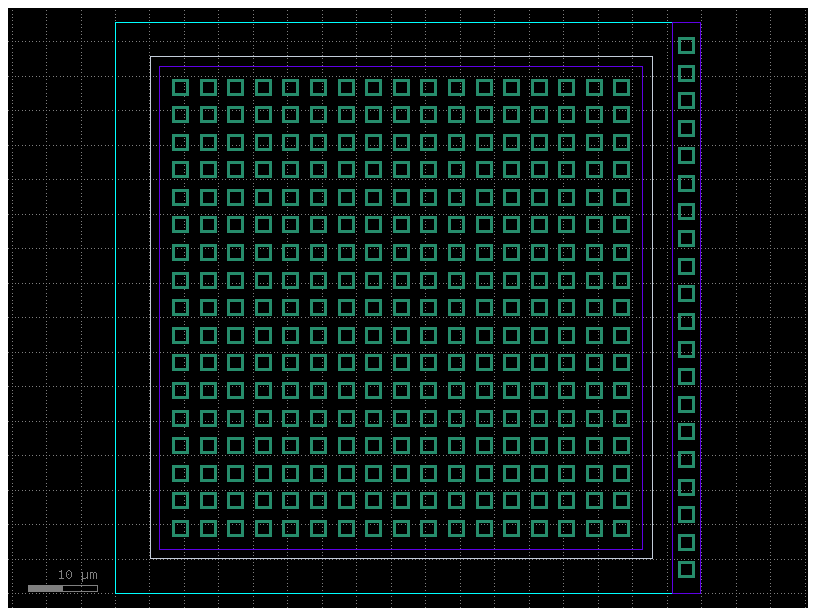

In [ ]:
# Generate mimcap with gdsfactory
from sky130.pcells import mimcap_1

# Capacitance formula (from .spice model)
w = 70
l = 70

m3_dw = -0.025e-6
tol_m3 = 0
camimc=  2.00e-15
cpmimc = 0.19e-15

wc = w + m3_dw*1e6 + tol_m3*1e6
lc = l + m3_dw*1e6 + tol_m3*1e6
carea = camimc*wc*lc
cperim = cpmimc*(wc+lc)*2
capacitance = carea + cperim

print(capacitance, "F")

capacitor1 = mimcap_1(
      m3_layer=(70, 20),
      via3_size=(2, 2),
      via3_layer=(70, 44),
      via3_enclosure=(0.9, 0.9),
      via3_spacing=(2, 2),
      m4_spacing=3,
      m4_r_length=4,
      m4_layer=(71, 20),
      m4_length=l,
      m4_width=w,
      capm_layer=(89, 44),
      m4_enclosure=(1.4, 1.4),
      capm_enclosure=(5, 5),
)
capacitor1.rename("capacitor1")

capacitor1.plot()

In [ ]:
capacitor1.write_gds("capacitor1.gds")

2023-12-03 18:51:00.895 | INFO     | gdsfactory.component:_write_library:1913 - Wrote to 'capacitor1.gds'


PosixPath('capacitor1.gds')

To generate the capacitor .lef, we can use Magic to read the .gds and write the .lef:

In [ ]:
%%writefile gds_to_lef.sh

# Assign input .gds file to a variable
input_gds_file="$1"

# Extract the file name from input .gds
file_name=$(basename -- "$input_gds_file")
file_name_no_ext="${file_name%.*}"

# Open magic and convert to gds
conda-env/bin/magic -dnull -noconsole -T conda-env/share/pdk/sky130A/libs.tech/magic/sky130A.tech -rcfile conda-env/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc <<EOF
gds read $input_gds_file
lef write $file_name_no_ext.lef
quit -noprompt
EOF

Writing gds_to_lef.sh


In [ ]:
%%shell
bash ./lef_to_gds.sh capacitor1.gds

For the resistances, we've chosen to not integrate them, and instead provide pins for external connections, as [SKY130 documentation](https://skywater-pdk.readthedocs.io/en/main/rules/device-details.html#generic-resistors) states that resistances from the PDK are not recommended for analog designs. This will increase parasitics in the device and is not ideal; in a proper scenario, two versions of the circuit should be tested in a lab $-$ one with integrated resistors, and another with external resistors $-$ to decide if performance is acceptable.

## Conclusion

In this project, we could use open-source software to design and simulate a MEMS resonator for breast cancer detection using biomarkers in both the mechanical and electrical domains. This approach was software-defined, allowing to easily change dimensions and possibly using optimization techniques to generate a better design. The mechanical modelling and pre-layout simulations validate an initial proof-of-concept for the possibility of having a fully-integrated AMS front-end driving such a device.

One can observe that this approach decoupled the mechanical MEMS and the AMS front-end circuits design and analysis. A multi-physics simulation would be required to validate the integrated design with respect to problems such as interaction between MEMS and CMOS structures, mechanical stress and others.

Moreover, one should remark that this is essentially a theoretical proof-of-concept to show the possibility of using MEMS resonators to detect biomarkers. In practice, if such a device were to be fabricated, the design process would be much more detailed and tested. In addition, it would probably be closely followed by a medical team with both biophysics and clinical expertise.

As next steps, the AMS front-end design would be refined, with a full integration of passive devices, inclusion of current/voltage references IPs, PVT + mismatch simulations, complete layout with post-layout simulations and implementation of design for testability (DfT) elements. Last but not least, the entire system would have to be thoroughly simulated for compliance with healthcare devices regulations, especially if installed in-vivo.

## References

<a id='ref1-biomarker'></a>
[1] “Biomarker tests and cancer treatment,” American Cancer Society, https://www.cancer.org/cancer/diagnosis-staging/tests/biomarker-tests.html (accessed Dec. 3, 2023).

<a id='ref2-HER2'></a>
[2] Morales, Luisa et al. Expresión del HER2/neu en pacientes venezolanas con cáncer de mama localmente avanzado. Invest. clín [online]. 2008, vol.49, n.1, pp.69-78.

<a id='ref3-coupledDETF'></a>
[3] P. Thiruvenkatanathan, J. Yan, J. Woodhouse and A. A. Seshia, "Enhancing Parametric Sensitivity in Electrically Coupled MEMS Resonators," in Journal of Microelectromechanical Systems, vol. 18, no. 5, pp. 1077-1086, Oct. 2009, doi: 10.1109/JMEMS.2009.2025999

<a id='ref4-HER2serum'></a>
[4] Shamshirian, A., Aref, A., Yip, G.W. et al. Diagnostic value of serum HER2 levels in breast cancer: a systematic review and meta-analysis. BMC Cancer 20, 1049 (2020). https://doi.org/10.1186/s12885-020-07545-2

<a id='ref5-cmosmems'></a>
[5] Qu H. CMOS MEMS Fabrication Technologies and Devices. Micromachines (Basel). 2016 Jan 21;7(1):14. doi: 10.3390/mi7010014. PMID: 30407387; PMCID: PMC6189935.

<a id='ref6-driecmosmems'></a>
[6] Tseng S-H (2022) CMOS MEMS Design and Fabrication Platform. Front. Mech. Eng 8:894484. doi: 10.3389/fmech.2022.894484


<a id='ref7-science'></a>
[7] “Silicon-on-Insulator Standard Technology,” Science, https://science.xyz/docs/d/mems-soi/index (accessed Dec. 3, 2023).


<a id='ref8-her2antibodies'></a>
[8] Hu X, Li D, Fu Y, Zheng J, Feng Z, Cai J and Wang P (2022) Advances in the Application of Radionuclide-Labeled HER2 Affibody for the Diagnosis and Treatment of Ovarian Cancer. Front. Oncol. 12:917439. doi: 10.3389/fonc.2022.917439

<a id='ref9-quantumdot'></a>
[9] Peckys, D.B., Hirsch, D., Gaiser, T. et al. Visualisation of HER2 homodimers in single cells from HER2 overexpressing primary formalin fixed paraffin embedded tumour tissue. Mol Med 25, 42 (2019). https://doi.org/10.1186/s10020-019-0108-z

<a id='ref10-layerbylayer'></a>
[10] Layer-by-Layer Deposition: Development and Applications. New York: Nova Science Publishers, Inc., 2020.

## Acknowledgments

To the open source silicon community, that is creating contest opportunities like this and changing the way engineers learn and use microelectronics for a better and more inclusive field.